In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import *
import time
import dataset as data
import matplotlib.pyplot as plt

In [2]:
rooms = data.rooms
courses = data.courses
students = data.students
constraints = data.constraints

In [3]:
# 21 courses, 150 classes
# 7 rooms
# 19 students

In [4]:
#### Pre-processing ####
rooms_id = [r['id'] for r in rooms]
students_id = [s['id'] for s in students]

# class-time pairs
classes = []
for course in courses:
    for subpart in course['subpart']:
        for c in subpart['class']:
            c['sbp_id'] = subpart['id']
            classes.append(c)
classes_id = [c['id'] for c in classes]

# student-subpart pairs
student_subparts = [
    (s, [c['id'] for c in subpart['class']])
    for s in students_id
    for course_id in students[s - 1]['course']
    for subpart in courses[course_id - 1]['subpart']
]

# student-classes pairs
student_classes = [
    (s, [c['id'] for course_id in students[s - 1]['course']
         for subpart in courses[course_id - 1]['subpart']
         for c in subpart['class']])
    for s in students_id
]

# pairs of classes with SameAttendee constraint
SA_pairs = [
    (ct['class'][i1], ct['class'][i2])
    for ct in constraints if ct['type'] == 'SameAttendees'
    for i1 in range(len(ct['class']))
    for i2 in range(i1 + 1, len(ct['class']))
]

def clash(time1, time2):
    clash_days = any(a & b for a, b in zip(map(int, time1['days']), map(int, time2['days'])))
    clash_weeks = any(a & b for a, b in zip(map(int, time1['weeks']), map(int, time2['weeks'])))
    overlap_start = time1['start'] < time2['start'] + time2['length']
    overlap_end = time1['start'] + time1['length'] > time2['start']
    return clash_days and clash_weeks and (overlap_start and overlap_end)

In [5]:
m = Model("timetabling")

# Create decision variables
x = m.addVars([(c, t) for c in classes_id for t in range(len(classes[c-1]['time']))], vtype=GRB.BINARY, name='x')
y = m.addVars([(c, r) for c in classes_id for r in range(len(classes[c-1]['room']))], vtype=GRB.BINARY, name='y')
z = m.addVars([(s, c) for s in students_id for c in student_classes[s-1][1]], vtype=GRB.BINARY, name='z')

# Objective function
obj = quicksum(x[c, t] * classes[c-1]['time'][t]['penalty'] for c in classes_id for t in range(len(classes[c-1]['time']))) + \
    quicksum(y[c, r] * classes[c-1]['room'][r]['penalty'] for c in classes_id for r in range(len(classes[c-1]['room'])))
m.setObjective(obj, GRB.MINIMIZE)

# Constraints
# 1. Every class must be assigned a time
m.addConstrs((x.sum(c, '*') == 1 for c in classes_id), "assign_time")

# 2. Every class must be assigned a room, where applicable
m.addConstrs((y.sum(c, '*') == 1 for c in classes_id), "assign_room")

# 3. Every student must attend exactly one class for each subpart
for s, subpart in student_subparts:
    m.addConstr(sum(z[s, c] for c in subpart) == 1, f"student_{s}_subpart")

# 4. For classes with a parent-child relationship, if a class is assigned to a student, 
# then the parent class must also be assigned
for s in students_id:
    for c in student_classes[s-1][1]:
        if 'parent' in classes[c-1]:
            m.addConstr(z[s, c] <= z[s, classes[c-1]['parent']], f"parent_child_{s}_{c}")

# 5. The capacity of each class in terms of the number of students must be satisfied
for c in classes_id:
    m.addConstr(sum(z[s, c] for s in students_id if c in student_classes[s-1][1]) <= classes[c-1]['limit'], f"class_capacity_{c}")

# 6. A room cannot be used when it is unavailable
for c in classes_id:
    for time_index, ctime in enumerate(classes[c-1]['time']):
        for room_index, room in enumerate(classes[c-1]['room']):
            croom = rooms[room['id'] - 1]
            for room_uat in croom['unavailable']:
                if clash(ctime, room_uat):
                    m.addConstr(x[c, time_index] + y[c, room_index] <= 1, f"room_availability_{c}_{time_index}_{room_index}")

                    
# 7. Satisfy 'SameAttendees' constraints for classes
for c1, c2 in SA_pairs:
    for time1_index, time1 in enumerate(classes[c1-1]['time']):
        for time2_index, time2 in enumerate(classes[c2-1]['time']):
            if clash(time1, time2):
                m.addConstr(x[c1, time1_index] + x[c2, time2_index] <= 1, f"same_attendees_{c1}_{c2}_{time1_index}_{time2_index}")


# 8. Two classes cannot be at the same time and in the same room
for c1, c2 in itertools.combinations(classes_id, 2):
    for time1_index, time1 in enumerate(classes[c1-1]['time']):
        for time2_index, time2 in enumerate(classes[c2-1]['time']):
            if clash(time1, time2):
                for room1_index, room1 in enumerate(classes[c1-1]['room']):
                    for room2_index, room2 in enumerate(classes[c2-1]['room']):
                        if room1['id'] == room2['id']:
                            m.addConstr(x[c1, time1_index] + x[c2, time2_index] + y[c1, room1_index] + y[c2, room2_index] <= 3, f"no_overlap_{c1}_{c2}_{time1_index}_{time2_index}_{room1_index}_{room2_index}")

# 9. Class limit is less than or equal to room capacity
for c in classes_id:
    class_capacity = classes[c-1]['limit']  # Class capacity
    for r, room in enumerate(classes[c-1]['room']):
        room_id = room['id']
        room_capacity = rooms[room_id - 1]['capacity']  # Room capacity
        # When y[c, r] being true (1) triggers the capacity check
        m.addConstr((y[c, r] * (room_capacity - class_capacity)) >= 0, f"room_capacity_{c}_{r}")

        
# Set the time limit in seconds
time_limit_seconds = 60 * 60
m.setParam(GRB.Param.TimeLimit, time_limit_seconds)

# Set the MIP gap limit
m.setParam(GRB.Param.MIPGap, 0.1) 

# Record the start time
start_time = time.time()

# Optimize model
m.optimize()

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Optimization took {elapsed_time} seconds")

# Create lists to store optimal solution values
x_values = []
y_values = []
z_values = []

# Append optimal values for x variables
for c, t in x:
    if x[c, t].x > 0:  # Assuming a binary variable
        x_values.append((c, t, x[c, t].x))

# Append optimal values for y variables
for c, r in y:
    if y[c, r].x > 0:  # Assuming a binary variable
        y_values.append((c, r, y[c, r].x))

# Append optimal values for z variables
for s, c in z:
    if z[s, c].x > 0:  # Assuming a binary variable
        z_values.append((s, c, z[s, c].x))

# Create DataFrames
x_df = pd.DataFrame(x_values, columns=['Class', 'Time', 'Value'])
y_df = pd.DataFrame(y_values, columns=['Class', 'Room', 'Value'])
z_df = pd.DataFrame(z_values, columns=['Student', 'Class', 'Value'])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-06
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-7267U CPU @ 3.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 601751 rows, 6272 columns and 2392312 nonzeros
Model fingerprint: 0x524d2227
Variable types: 0 continuous, 6272 integer (6272 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 57110 rows and 145 columns (presolve time = 5s) ...
Presolve removed 57484 rows and 414 columns (presolve time = 10s) ...
Presolve removed 57785 rows and 1287 columns
Presolve time: 11.13s
Presolved: 543966 rows, 4985 columns, 2094040 nonzeros
Variable types: 0 continuous, 4985 integer (4985 binary)
Root relaxa

In [6]:
def save_df_to_jpg(df, title, jpg_filename):
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.table(cellText=df.values,
              colLabels=df.columns,
              cellLoc='center',
              loc='center')
    plt.axis('off')
    plt.title(title)
    plt.savefig(jpg_filename, format='jpg', bbox_inches='tight')
    print(f"{title} saved to {jpg_filename}")

Optimal solution for x:
     Class  Time  Value
0        1     1    1.0
1        2     9    1.0
2        3     6    1.0
3        4    30    1.0
4        5    26    1.0
..     ...   ...    ...
145    146    16    1.0
146    147    37    1.0
147    148    27    1.0
148    149    30    1.0
149    150    22    1.0

[150 rows x 3 columns]
Optimal solution for x saved to x_result.jpg


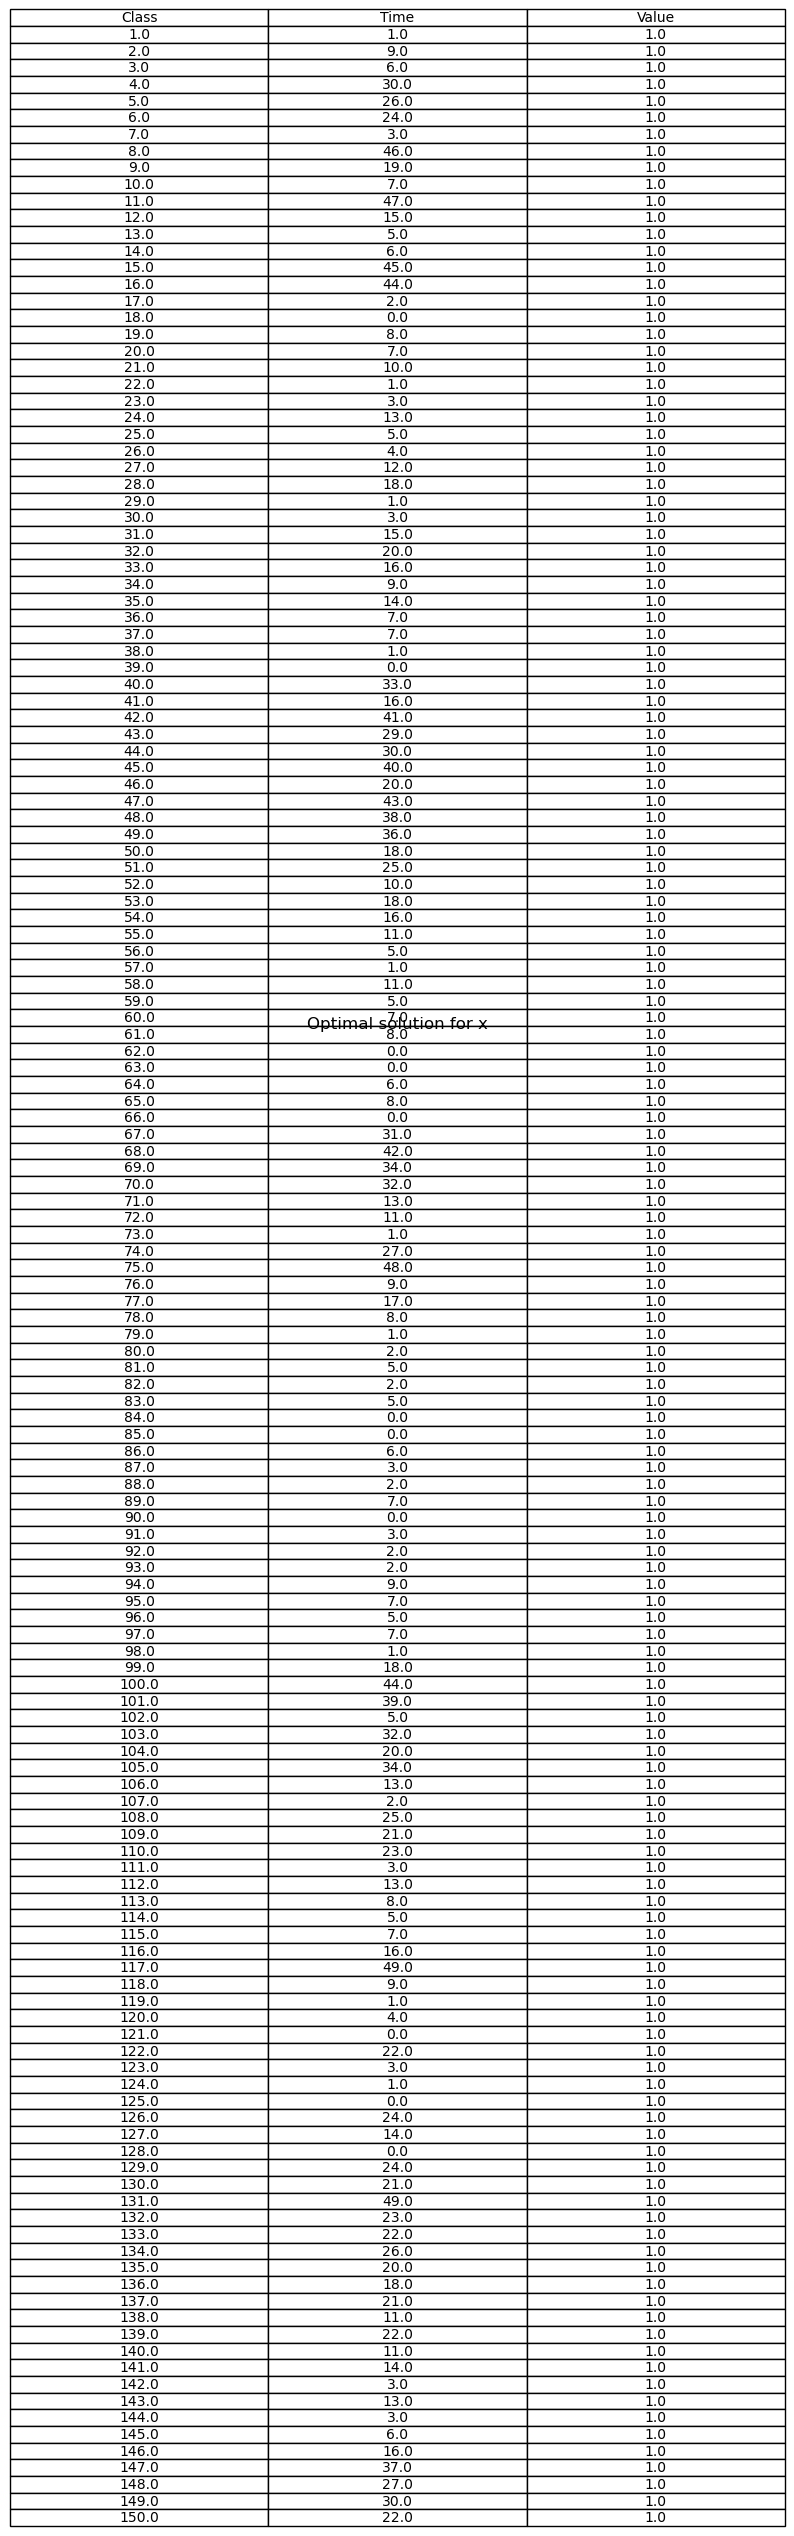

In [7]:
# Display DataFrames
print("Optimal solution for x:")
print(x_df)
save_df_to_jpg(x_df, 'Optimal solution for x', 'x_result.jpg')


Optimal solution for y:
     Class  Room  Value
0        1     1    1.0
1        2     0    1.0
2        3     0    1.0
3        4     0    1.0
4        5     0    1.0
..     ...   ...    ...
145    146     1    1.0
146    147     0    1.0
147    148     0    1.0
148    149     0    1.0
149    150     0    1.0

[150 rows x 3 columns]
Optimal solution for y saved to y_result.jpg


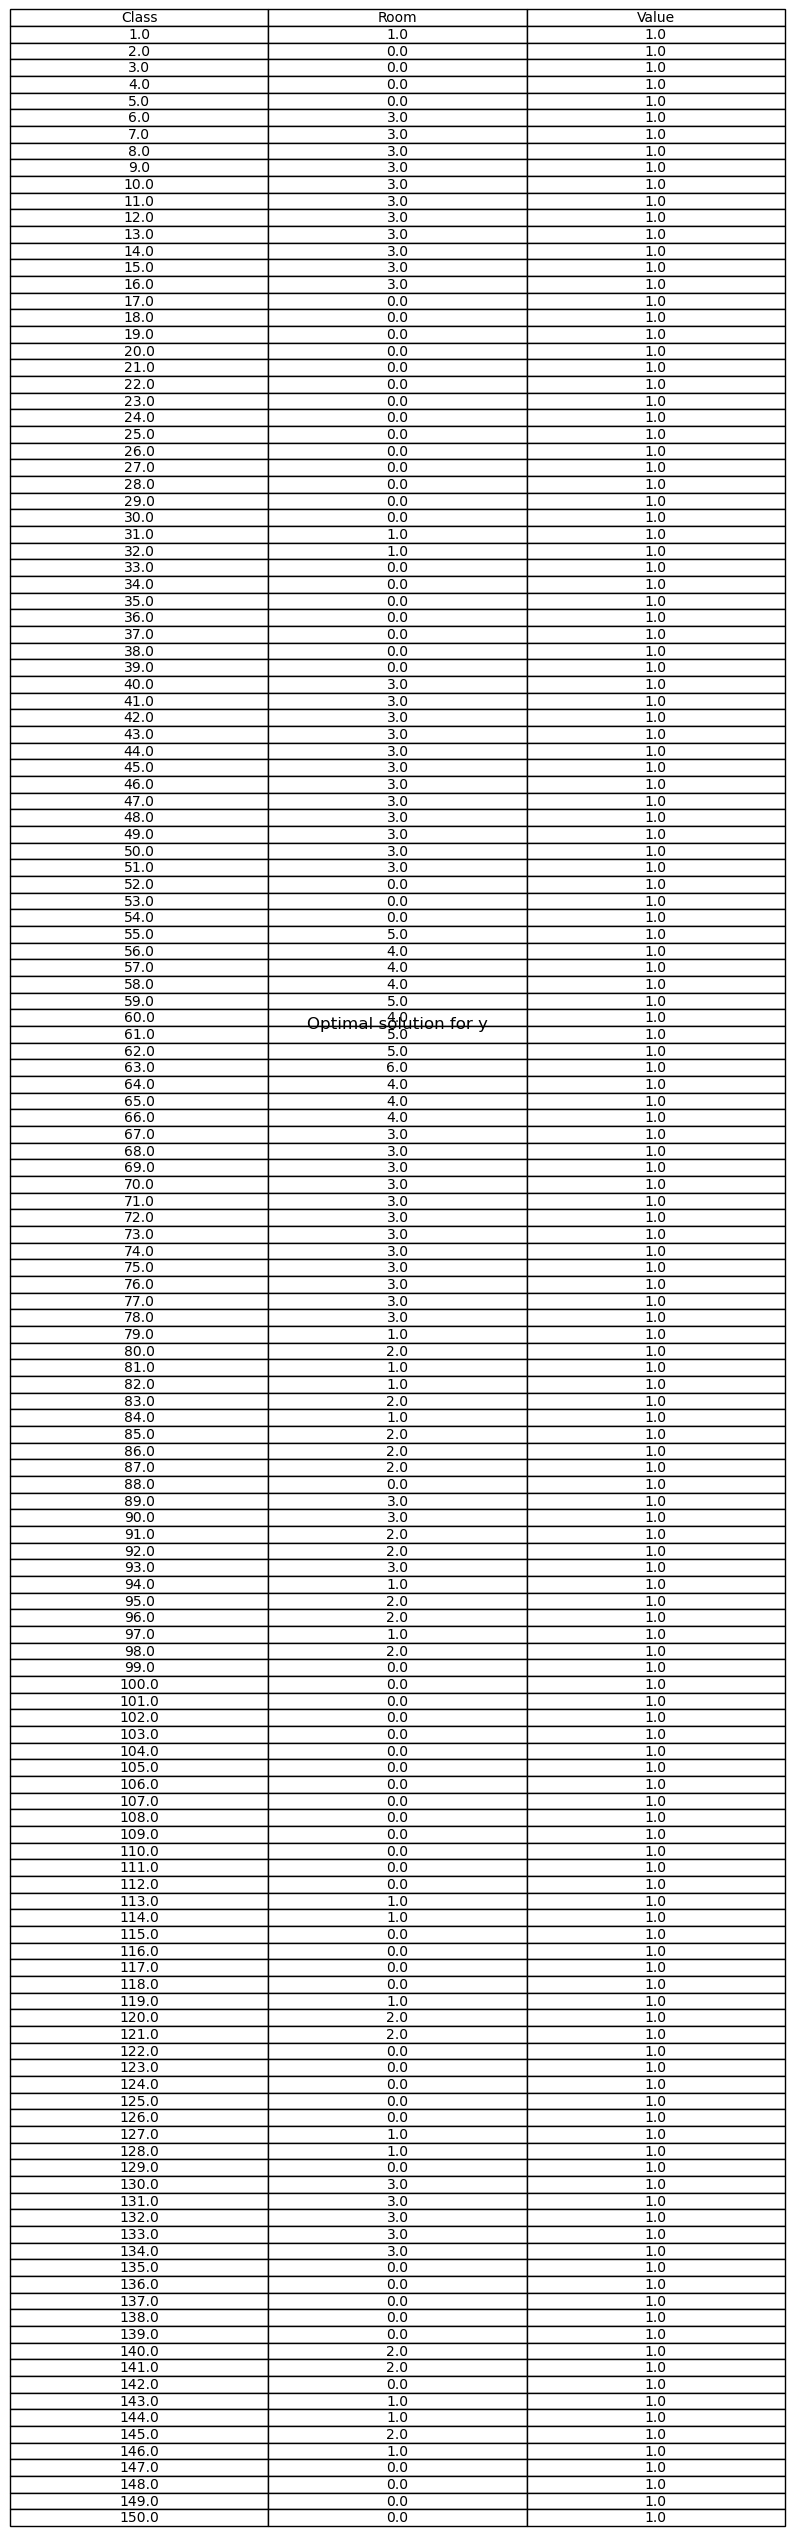

In [8]:
print("\nOptimal solution for y:")
print(y_df)
save_df_to_jpg(y_df, 'Optimal solution for y', 'y_result.jpg')


Optimal solution for z:
     Student  Class  Value
0          1      1    1.0
1          1    142    1.0
2          1    144    1.0
3          1     82    1.0
4          1     88    1.0
..       ...    ...    ...
194       19     31    1.0
195       19     36    1.0
196       19     39    1.0
197       19     48    1.0
198       19     85    1.0

[199 rows x 3 columns]
Optimal solution for z saved to z_result.jpg


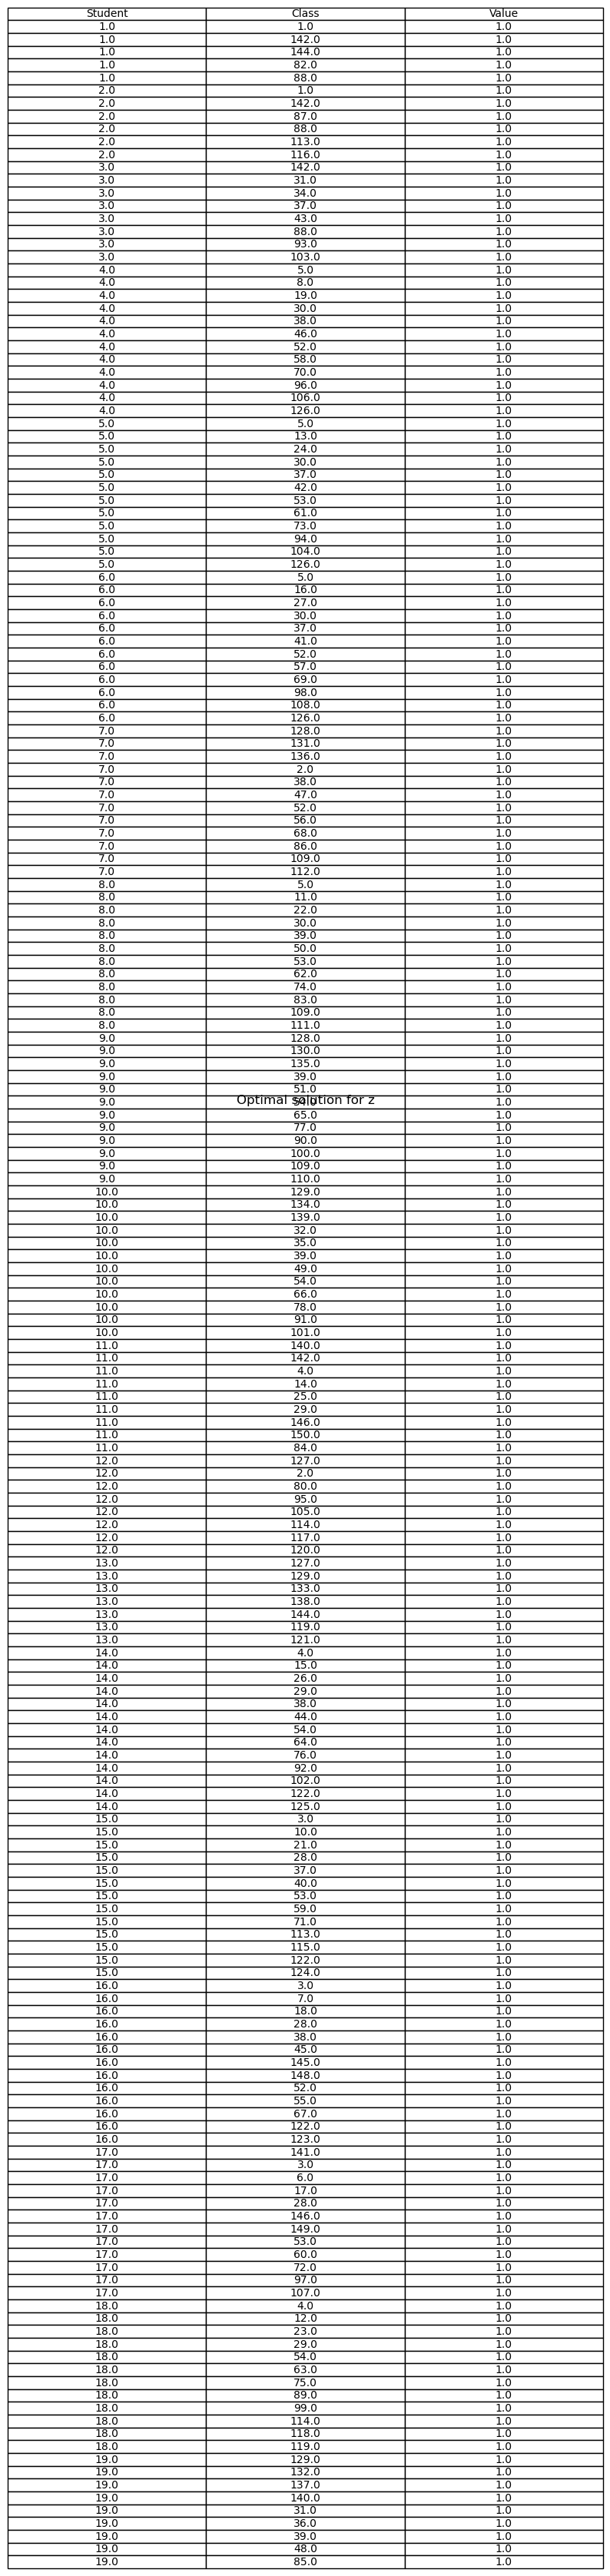

In [9]:
print("\nOptimal solution for z:")
print(z_df)
save_df_to_jpg(z_df, 'Optimal solution for z', 'z_result.jpg')

In [10]:
# Display the optimal objective value
print(f"\nOptimal Objective Value: {m.ObjVal}")

# Check the solver status after optimization
status = m.status

# Print or log the status
print(f"Solver Status: {status}")

# Interpret the status
if status == GRB.OPTIMAL:
    print("Optimal solution found.")
elif status == GRB.INFEASIBLE:
    print("The model is infeasible.")
elif status == GRB.UNBOUNDED:
    print("The model is unbounded.")
elif status == GRB.TIME_LIMIT:
    print("The solver reached the time limit.")
elif status == GRB.ITERATION_LIMIT:
    print("The solver reached the iteration limit.")
# Add more conditions as needed based on Gurobi status values

# Additional information
if status in [GRB.INFEASIBLE, GRB.UNBOUNDED]:
    # Print or log additional information about infeasibilities or unboundedness
    print("Additional information:", m.computeIIS())  # IIS: Irreducible Infeasible Subset


Optimal Objective Value: 16.0
Solver Status: 9
The solver reached the time limit.


In [11]:
# Assuming 'm' is your Gurobi model
total_constraints = m.numConstrs

# Print the total number of constraints
print(f"Total number of constraints: {total_constraints}")

Total number of constraints: 601751
